## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [401]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
runs = [306121, 306122, 306125, 306126]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306121
Loading 306122
Loading 306125
Loading 306126
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [5]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [6]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [7]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [8]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [9]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [10]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

306121 2017-11-03 13:10:09 2017-11-03 13:52:52 42 152 111
306122 2017-11-03 13:53:18 2017-11-03 14:46:08 1 137 137
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007
306126 2017-11-04 10:14:24 2017-11-04 13:28:39 1 501 501


Reindexing the dataframe after removing some lines:

In [11]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [12]:
print len(int_lumi2.index)

3756


Filling end time column:

In [13]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Plotting the instantaneous luminosities:

In [14]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

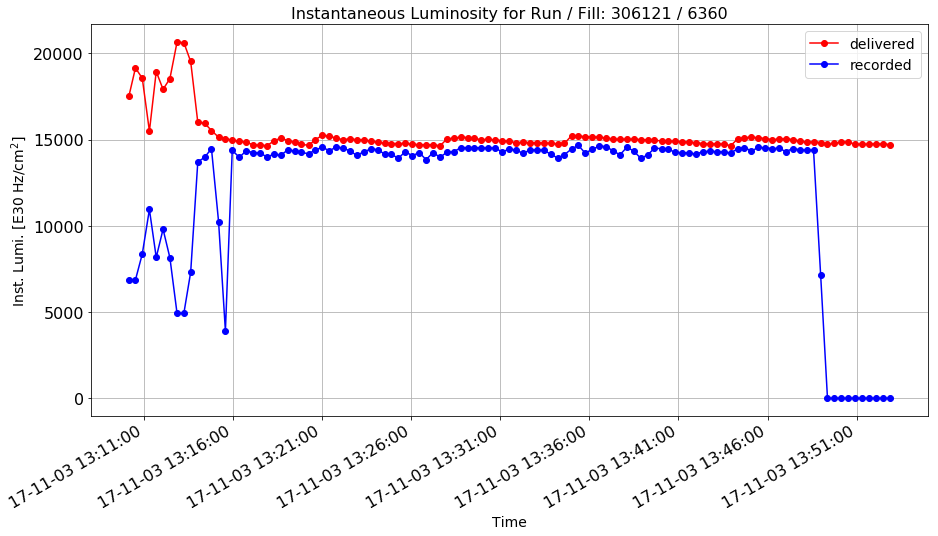

In [15]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306121]["time"], 
               int_lumi2[int_lumi2["run"] == 306121]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306121]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[0], int_lumi2["fill"].iloc[0])))

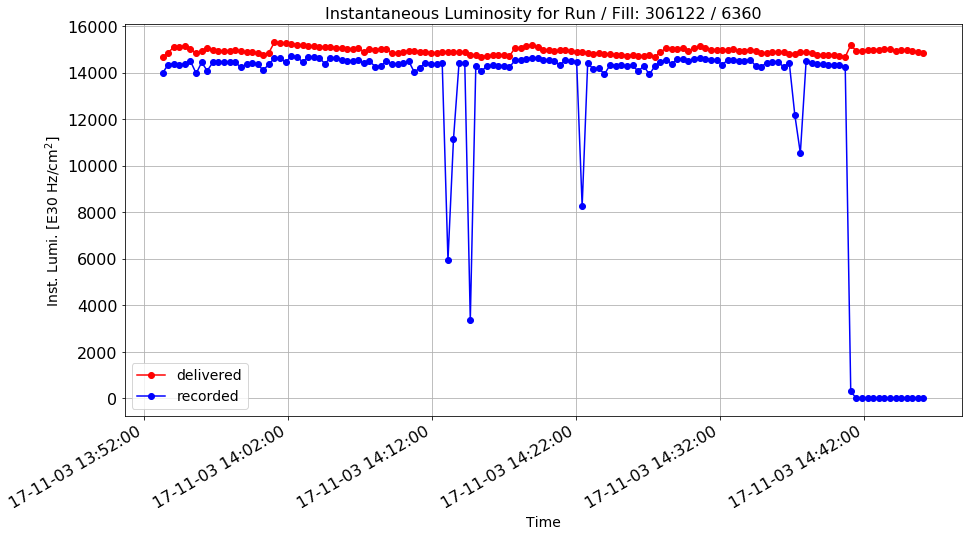

In [16]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306122]["time"], 
               int_lumi2[int_lumi2["run"] == 306122]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306122]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[1], int_lumi2["fill"].iloc[0])))

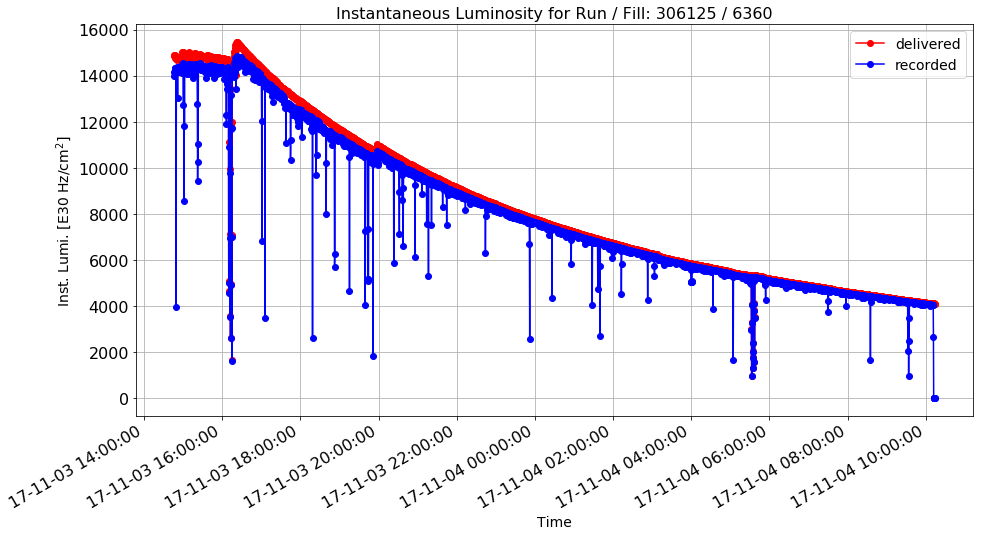

In [17]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[2], int_lumi2["fill"].iloc[0])))

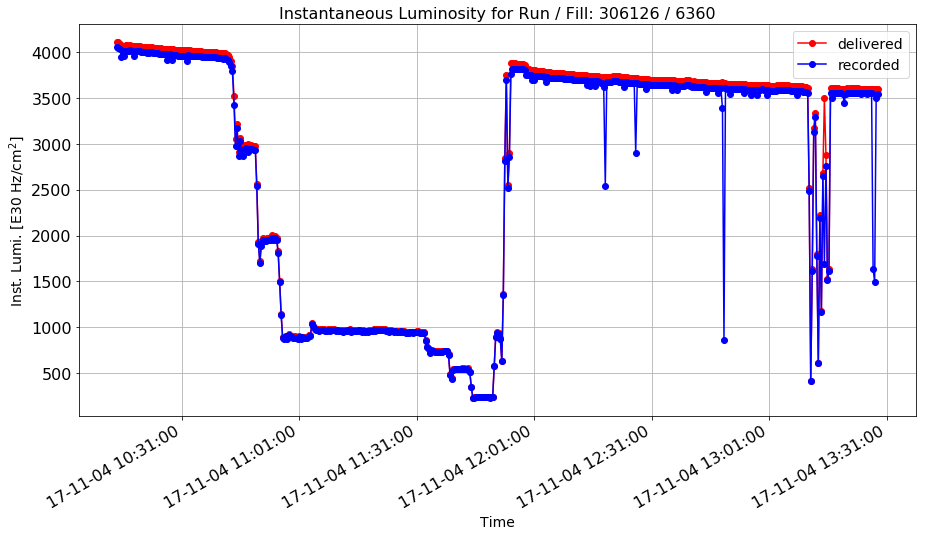

In [18]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306126]["time"], 
               int_lumi2[int_lumi2["run"] == 306126]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306126]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[3], int_lumi2["fill"].iloc[0])))

In [19]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [20]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [21]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [22]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

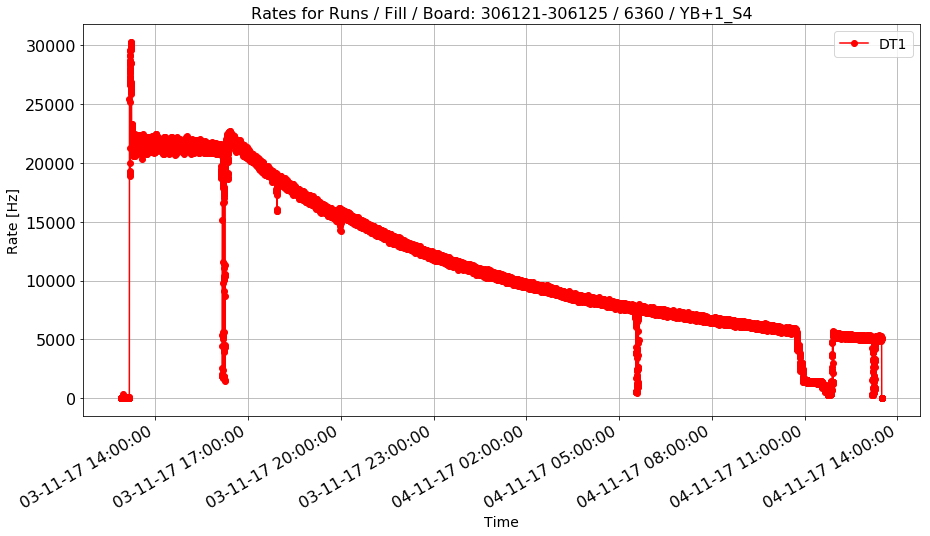

In [23]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[2]), 
                   int_lumi2["fill"].iloc[2], "YB+1_S4"))

Associating a LS and an instantaneous luminosity to each rate:

In [24]:
#Just a backup copy
df_rates_backup = df_rates.copy()

In [25]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [26]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-11-03 13:10:09 2017-11-04 13:28:39
Duplicates: 1593649


In [27]:
print len(df_rates_noduplicates)

27011


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [28]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


Removing the few cases not assigned and that are still at -1:

In [29]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

26997


Save in a csv file:

In [30]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [31]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [32]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print index
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000
1050000
1080000
1110000
1140000
1170000
1200000
1230000
1260000
1290000
1320000
1350000
1380000
1410000
1440000
1470000
1500000
1530000
1560000
1590000
1620000


Save another backup copy:

In [33]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [34]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [35]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [36]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print len(df_boards)
#print df_boards

60


Too slow to use all the measurements. Averaging over 10 LS:

In [37]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

In [38]:
def assignGroup(data, div = 10):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [39]:
#print df_rates["group"]

In [40]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4": "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

Calculating the errors on the mean values calculated in the previous step:

In [41]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

In [42]:
#print df_rates

Check for null or NaN values:

In [43]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
#df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False
Empty DataFrame
Columns: []
Index: []


In [44]:
#Another backup
#df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates.csv", sep='\t')

In [45]:
#Restore backup
#df_rates = df_rates_backup.copy()

In [46]:
print len(df_rates)

22560


Uncomment to check just one case:

In [47]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

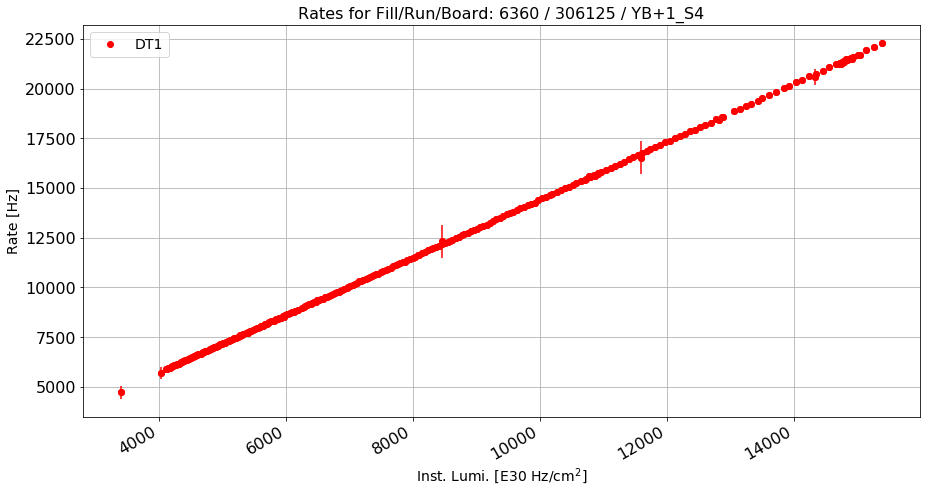

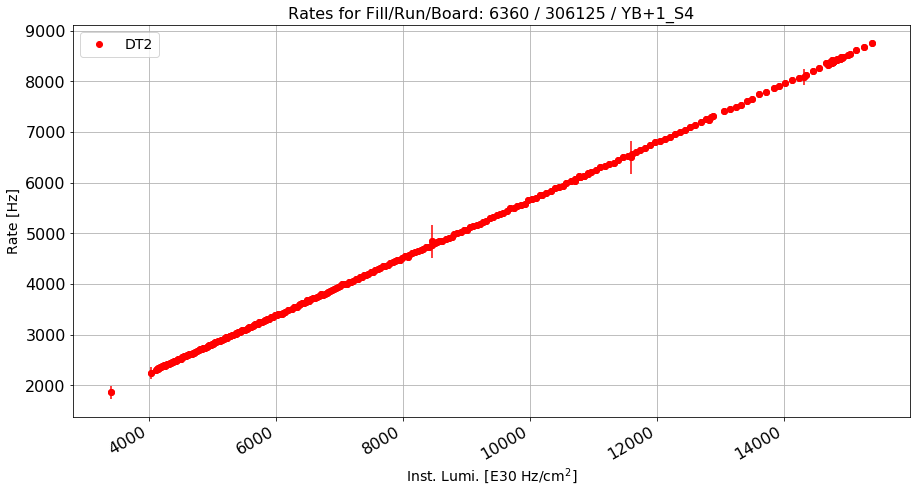

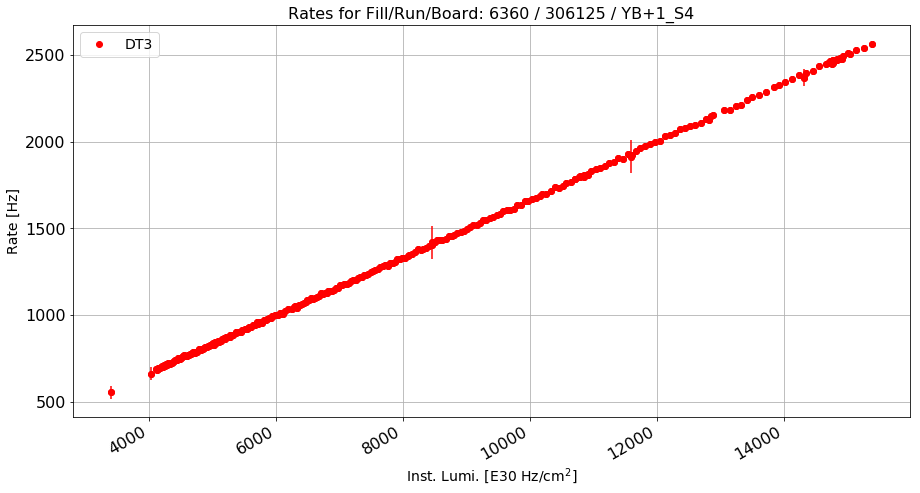

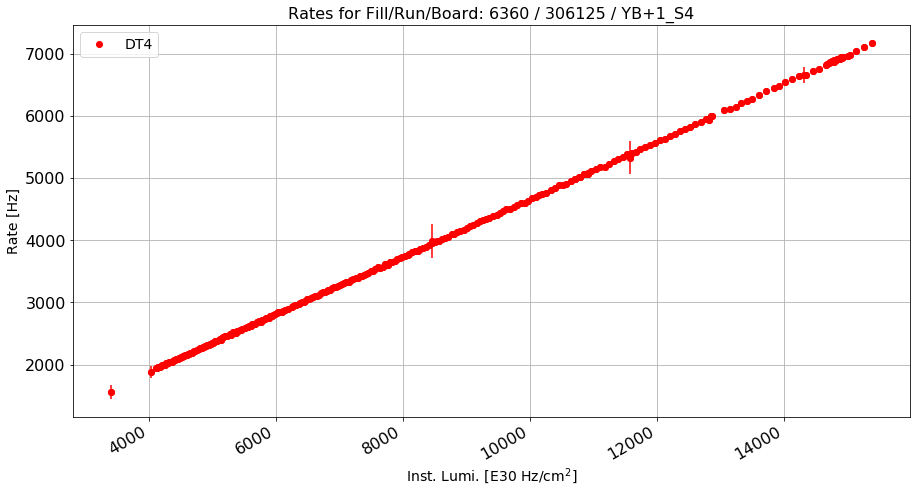

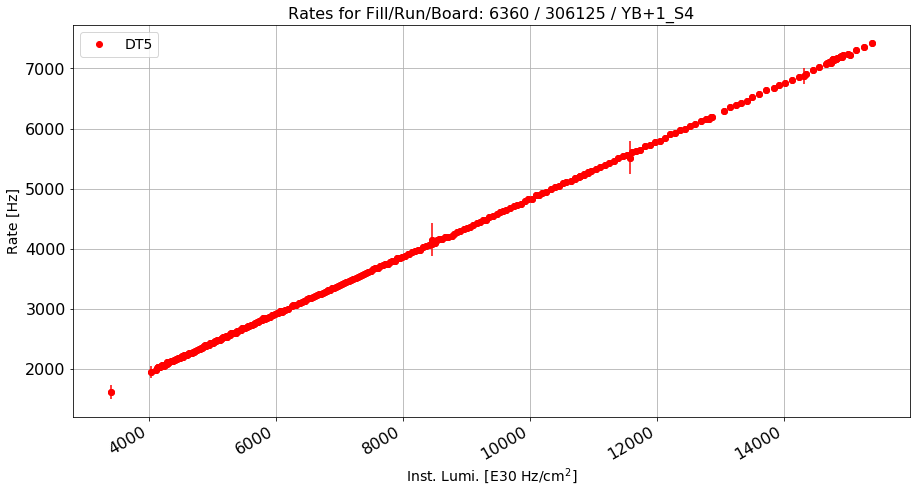

In [48]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"

plot_rate_vs_ls(df_rates, 306125, "lumi", "DT1", "YB+1_S4", 0, "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "DT2", "YB+1_S4", 0, "errDT2", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "DT3", "YB+1_S4", 0, "errDT3", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "DT4", "YB+1_S4", 0, "errDT4", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "DT5", "YB+1_S4", 0, "errDT5", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

Create a new dataframe with the input features already organized in a numpy array:

In [49]:
print df_rates.columns

Index([u'run', u'group', u'board', u'wheel', u'sector', u'ls', u'lumi',
       u'RPC1', u'RPC2', u'RPC3', u'RPC4', u'DT1', u'DT2', u'DT3', u'DT4',
       u'DT5', u'errDT1', u'errDT2', u'errDT3', u'errDT4', u'errDT5',
       u'errLumi', u'errRPC1', u'errRPC2', u'errRPC3', u'errRPC4', u'counts'],
      dtype='object')


In [50]:
#algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5']
algos = ['DT1', 'DT2', 'DT3', 'DT4', 'DT5']
df_rates_new = pd.DataFrame(columns=["run", "wheel", "sector", "station", "group", "content", "score"])
k = 0
for index, row in df_rates.iterrows():
    for j in algos:
        k = k + 1
        if(k%5000 == 0):
            print k
        #print j
        system = -1
        station = -1
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        #num = j.replace("RPC", "")
        num = j.replace("DT", "")
        station = int(num)
        CS = -1
        errCS = -1
        if (row[j] != 0):
            CS = row["lumi"]/row[j]
            errCS = (1/row[j])*math.sqrt(row["errLumi"]*row["errLumi"] + CS*CS*row["err"+j]*row["err"+j])
        #print CS, errCS
        array = [system, row["wheel"], row["sector"], station, round(row[j], 4), round(row["err"+j], 4),\
                 round(row["lumi"], 4), round(row["errLumi"], 4), round(CS, 4), round(errCS, 4)]
        #print array
        df_rates_new = df_rates_new.append({"run":row["run"],
                                            "wheel":row["wheel"], 
                                            "sector":row["sector"], 
                                            "station":station, 
                                            "group":row["group"], 
                                            "content":array, 
                                            "score":-1}, ignore_index=True)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000


# Model training section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [51]:
normalies = df_rates_new.copy()
anomalies = df_rates_new.copy()

In [52]:
print len(normalies), len(anomalies)

112800 112800


In [53]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344, 4.4609, 0.0731]
Anomalous chimney:
[2, 1, 4, 3, 3071.4035, 40.4563, 17987.064, 173.3344, 5.8563, 0.0956]


In [54]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [55]:
#rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [56]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        group = df.loc[i]["group"]
        run = df.loc[i]["run"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) &\
            (df["group"] == group) & (df["run"] == run)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[4] #good rate from the symmetric sector
            err = array[5] #uncertainty on the good rate from the symmetric sector
            CS = array[8]
            errCS = array[9]
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = rate
            content[5] = err
            content[8] = CS
            content[9] = errCS
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = -1
            content[5] = -1
            content[8] = -1
            content[9] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [57]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344, 4.4609, 0.0731]
Anomalous chimney:
[2, 1, 4, 3, 4032.193, 53.42, 17987.064, 173.3344, 4.4609, 0.0731]


In [58]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print "Normal chimney:"
print anomalies[rule]["content"].iloc[0]

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print "Anomalous chimney:"
print anomalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344, 4.4609, 0.0731]
Anomalous chimney:
[2, 1, 4, 3, 3071.4035, 40.4563, 17987.064, 173.3344, 5.8563, 0.0956]


In [59]:
#Scale the data
def scale_data(data):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [60]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [744]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[anomalies.score == 1]
normalies = normalies[normalies.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

376 faults and 112800 good samples. In total: 113176.


In [687]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 300
Number of normal in the train set: 90240
Number of anomalies in the test set: 76
Number of normal in the test set: 22560


In [494]:
#print anomalies

In [548]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [587]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 10))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [745]:
def cae_generate_input():
    return np.array(np.concatenate(normalies.content_scaled.values)).reshape(-1, 10)

train_cae = cae_generate_input()

In [589]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print cw

{0: 0.50166223404255317, 1: 150.90000000000001}


Defining NN structure:

In [789]:
dim = 10
def neural_network_1():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_2():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_3():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_4():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(32, activation='relu', name="dense_ann4"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def autoencoder():
    from keras.layers import Input, Dense
    from keras.models import Model
    input_ = Input(shape=(10,))
    encoded = Dense(10, activation='relu')(input_)
    encoded = Dense(9, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(6, activation='relu')(encoded)
    
    decoded = Dense(6, activation='relu')(encoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded = Dense(9, activation='relu')(decoded)
    decoded = Dense(10, activation='sigmoid')(decoded)

    autoencoder = Model(input_, decoded)
    return autoencoder

In [790]:
ann_1 = neural_network_1()
ann_2 = neural_network_2()
ann_3 = neural_network_3()
ann_4 = neural_network_4()
cae = autoencoder()
print("Neural Network Architecture:")
ann_1.summary()
ann_2.summary()
ann_3.summary()
ann_4.summary()
print("Autoencoder Architecture:")
cae.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 10)                0         
_________________________________________________________________
dense_ann (Dense)            (None, 32)                352       
_________________________________________________________________
output_ann (Dense)           (None, 2)                 66        
Total params: 418
Trainable params: 418
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 10, 1)             0         
_________________________________________________

Training the NN:

In [703]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [71]:
history_ann_1 = train_nn(ann_1,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_1",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

In [72]:
history_ann_2 = train_nn(ann_2,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_2",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 05119: early stopping


In [73]:
history_ann_3 = train_nn(ann_3,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_3",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

In [74]:
history_ann_4 = train_nn(ann_4,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_4",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 02390: early stopping


In [802]:
history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)

Epoch 00104: early stopping


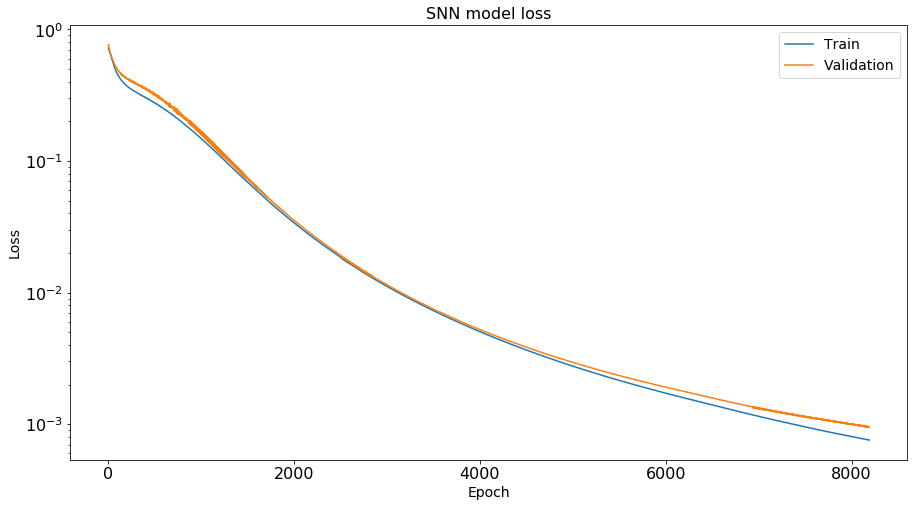

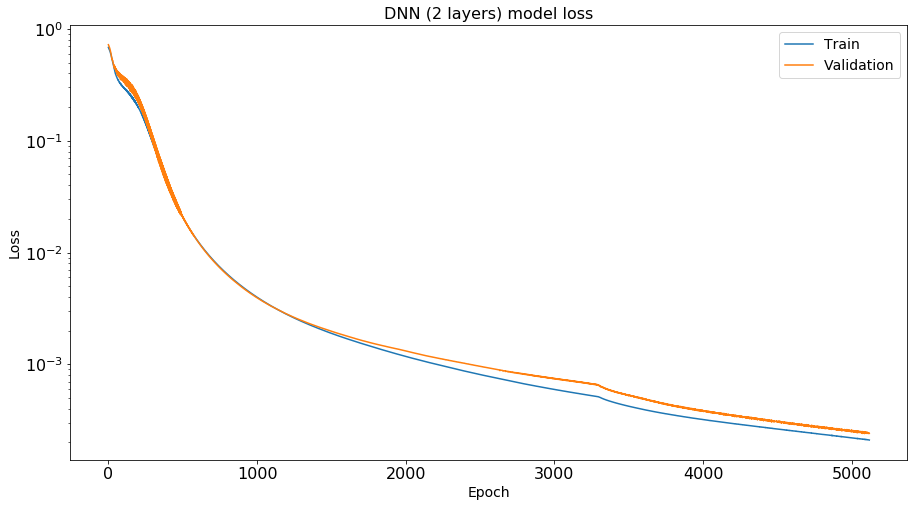

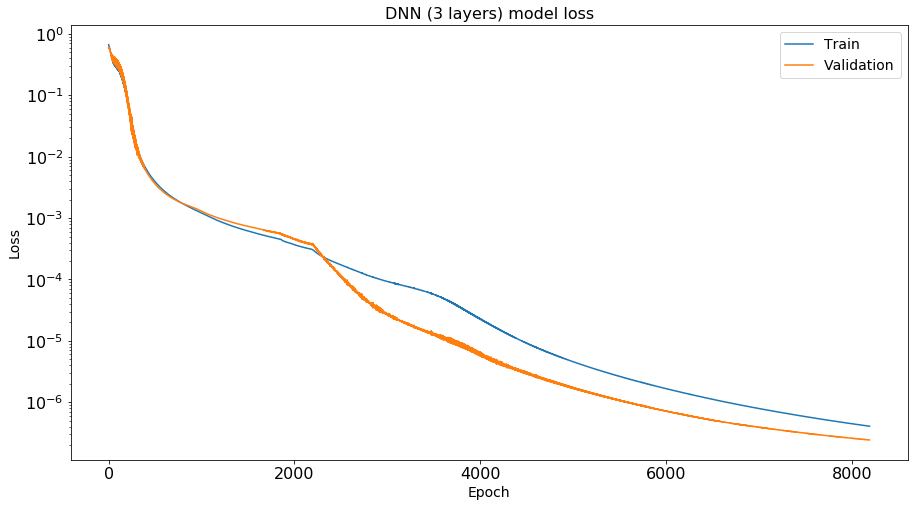

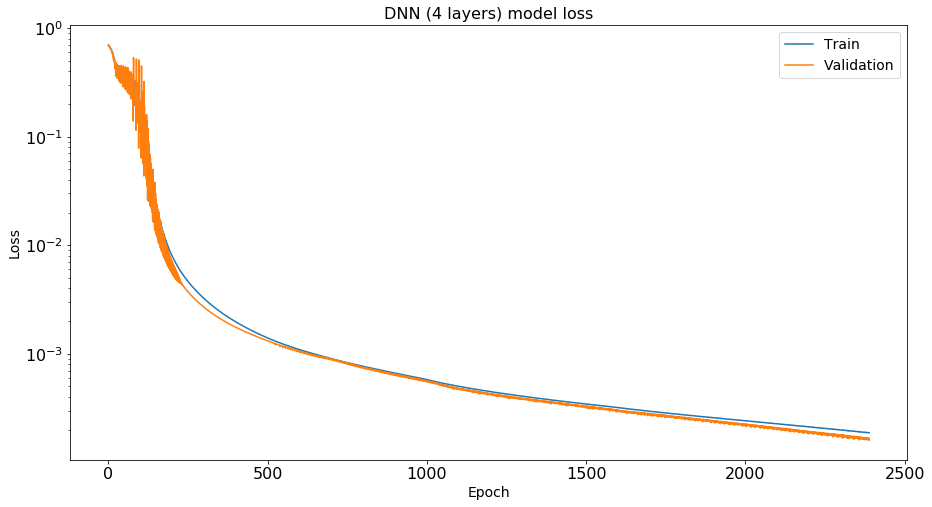

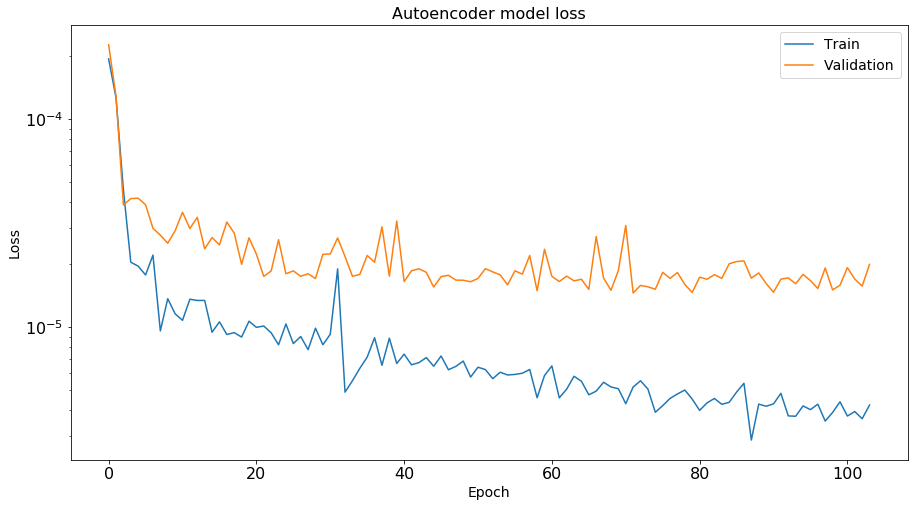

In [803]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.yscale("log")
    plt.show();

plot_training_loss(history_ann_1.history, "SNN model loss")
plot_training_loss(history_ann_2.history, "DNN (2 layers) model loss")
plot_training_loss(history_ann_3.history, "DNN (3 layers) model loss")
plot_training_loss(history_ann_4.history, "DNN (4 layers) model loss")
plot_training_loss(history_cae.history, "Autoencoder model loss")

Making an inference using the model and the test sample:

In [768]:
ann_model_1 = load_model("./model_keras/ann_1.h5")
ann_model_2 = load_model("./model_keras/ann_2.h5")
ann_model_3 = load_model("./model_keras/ann_3.h5")
ann_model_4 = load_model("./model_keras/ann_4.h5")

In [769]:
layers_test["ann_score_1"] = ann_model_1.predict(np.array(test_x))[:, 1]
layers_test["ann_score_2"] = ann_model_2.predict(np.array(test_x))[:, 1]
layers_test["ann_score_3"] = ann_model_3.predict(np.array(test_x))[:, 1]
layers_test["ann_score_4"] = ann_model_4.predict(np.array(test_x))[:, 1]

In [804]:
cae_model = load_model("./model_keras/cae.h5")

In [805]:
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [483]:
#print layers_test["ann_score"]
#print layers_test["score"]

In [795]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
print "DNN:"
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score_4"], 0.2)
print "AE:"
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.04)

DNN:
Model accuracy: 0.9997
Model sensitivity: 1.0
Model specificity: 0.9997
AE:
Model accuracy: 0.9715
Model sensitivity: 0.0263
Model specificity: 0.9747


In [81]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

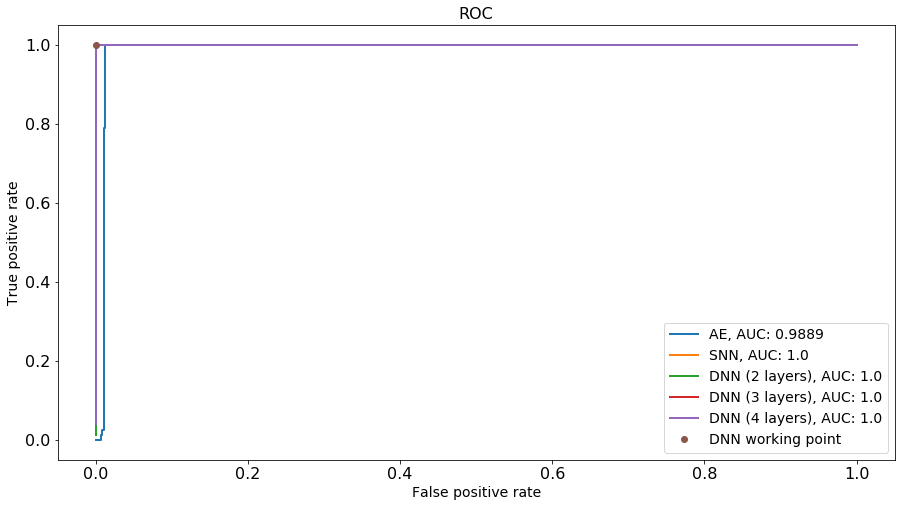

In [806]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("SNN", "ann_score_1"),
               ("DNN (2 layers)", "ann_score_2"),
               ("DNN (3 layers)", "ann_score_3"),
               ("DNN (4 layers)", "ann_score_4"),
               ], (specificity_ann, sensitivity_ann))

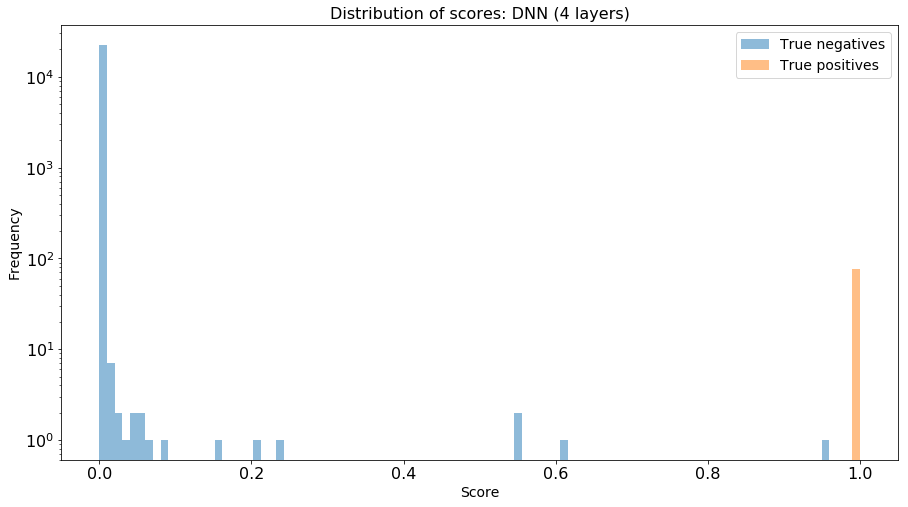

In [83]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score_4"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score_4"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: DNN (4 layers)")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

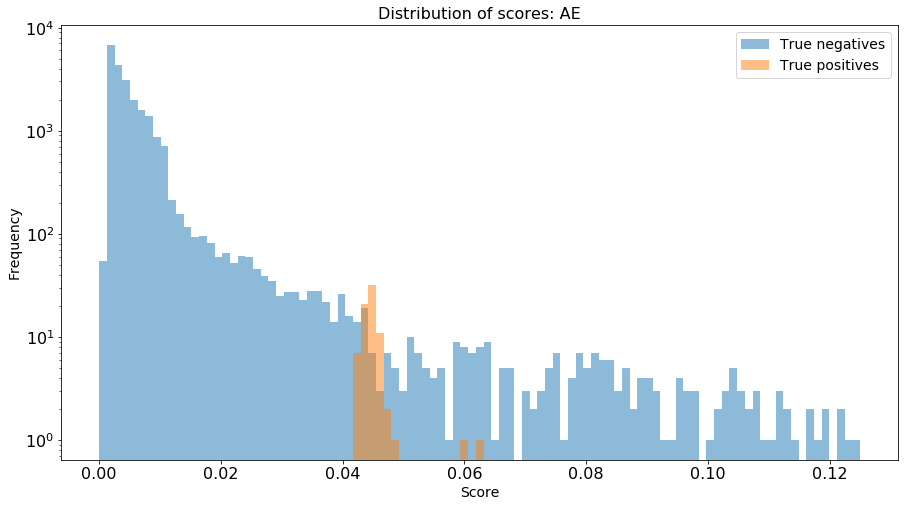

In [807]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [85]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[  9.99822695e-01   1.77304965e-04]
 [  0.00000000e+00   1.00000000e+00]]


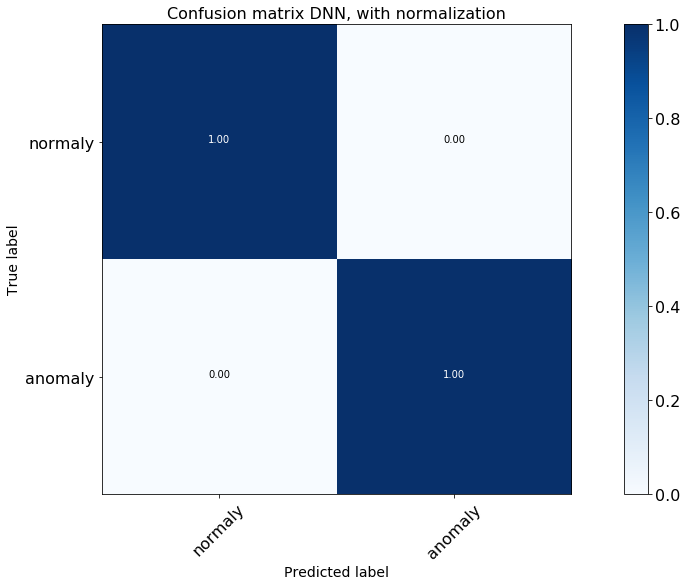

In [86]:
threshold = 0.5
y_pred = 2*(layers_test["ann_score_4"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix DNN, with normalization')

Normalized confusion matrix
[[ 0.98612589  0.01387411]
 [ 0.          1.        ]]


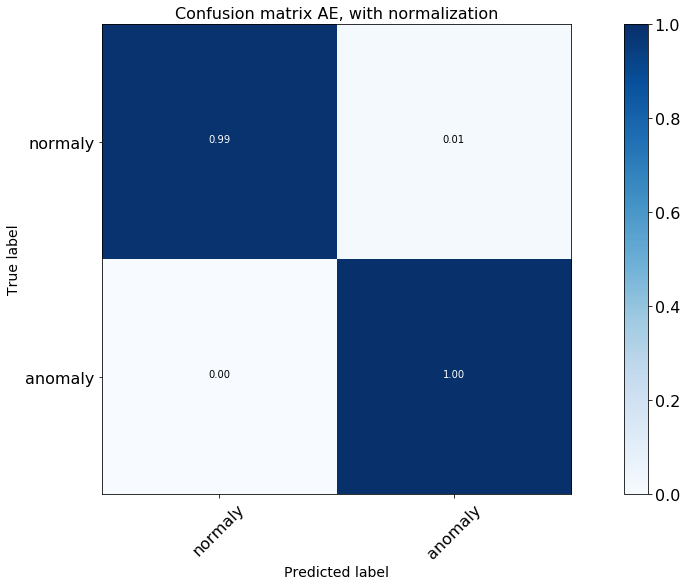

In [808]:
threshold = 0.04
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix AE, with normalization')

In [118]:
print "Number of FPs for the DNN:", len(layers_test[(layers_test["score"] == -1) & (layers_test["ann_score_4"] > 0.5)])

Number of FPs for the DNN: 4


In [809]:
print "Number of FPs for the AE:", len(layers_test[(layers_test["score"] == -1) & (layers_test["cae_score"] > 0.035)])

Number of FPs for the AE: 397


In [810]:
layers_test["name"] = ("W" + layers_test["wheel"].astype(str) + "_S" + layers_test["sector"].astype(str) +\
       "_St" + layers_test["station"].astype(str))

Where are the FPs located?

In [811]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['run', 'wheel', 'sector', 'station', 'name']).size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 1]
    #print df_temp
    return len(df_temp), df_temp

num_fp_ann, fp_ann = count_fp(layers_test, "ann_score_4", 0.5, False)
num_fp_cae, fp_cae = count_fp(layers_test, "cae_score", 0.035, True)

print "Number of chambers with false positives DNN:", num_fp_ann
print "Number of chambers with false positives AE:", num_fp_cae
fp_cae.set_index("name",drop=True,inplace=True)
fp_ann.set_index("name",drop=True,inplace=True)

Number of chambers with false positives DNN: 2
Number of chambers with false positives AE: 100


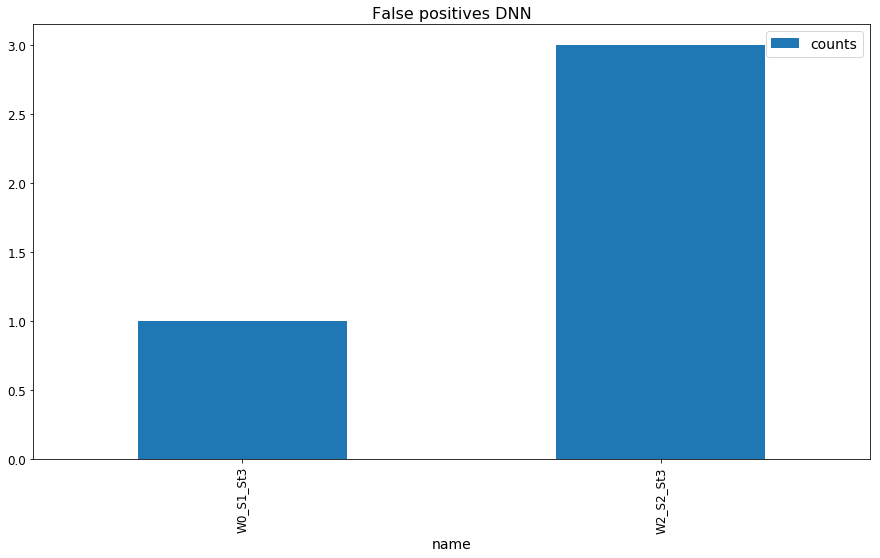

In [812]:
fp_ann["counts"].plot(kind='bar', title ="False positives DNN", legend=True, fontsize=12)

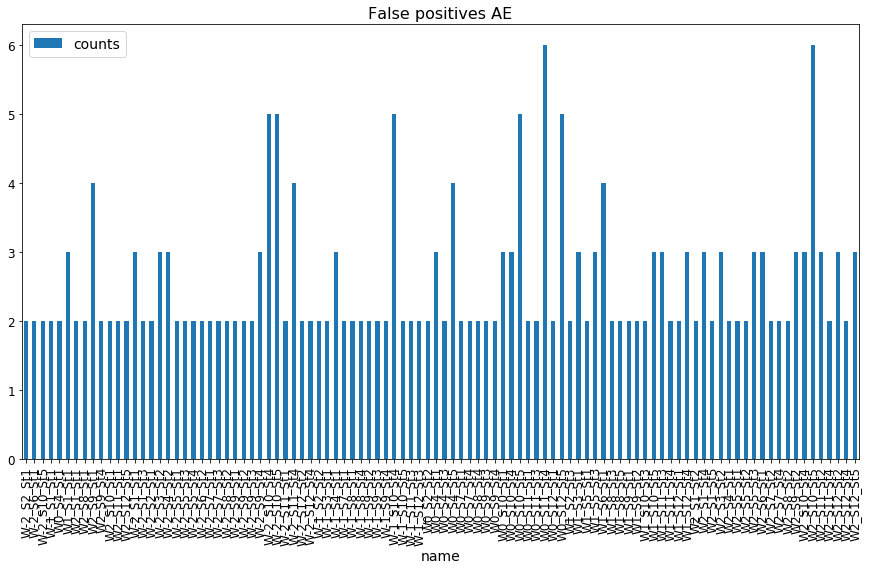

In [813]:
fp_cae["counts"].plot(kind='bar', title ="False positives AE", legend=True, fontsize=12)

In [814]:
def get_matrix(df):
    x = np.zeros((5,12),dtype=int)
    for i in range(len(df)):
        a = int(5-df["station"].iloc[i])
        b = int(df["sector"].iloc[i]-1)
        x[a,b] = x[a,b] + 1
    return x

def deduceLS(data):
    return data*10+5
layers_test["averageLS"] = layers_test["group"].apply(deduceLS)

[[1 0 1 0 0 0 0 0 0 2 0 2]
 [1 0 0 0 0 0 0 0 3 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2 0 2 3 3 1 2 3 1 0 3]]
35


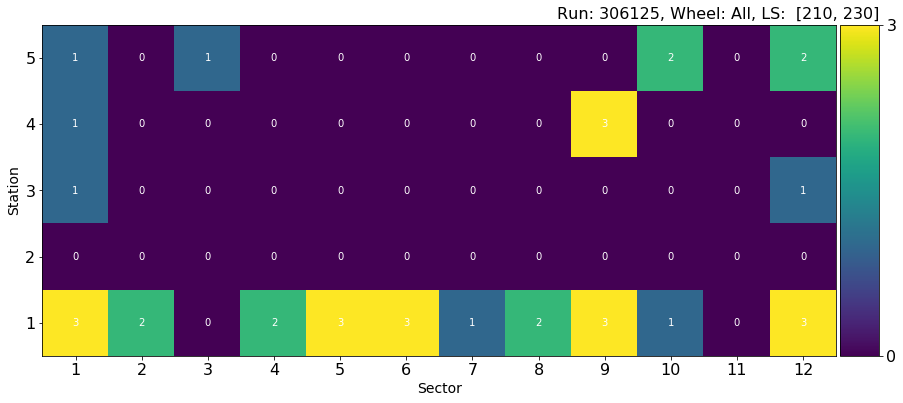

[[0 0 1 0 0 2 0 0 1 7 0 0]
 [1 1 1 1 2 1 1 0 4 6 4 2]
 [2 0 0 1 2 0 2 0 2 0 1 1]
 [2 1 3 3 1 2 2 3 2 1 1 2]
 [3 4 1 0 2 3 2 1 3 2 3 2]]
95


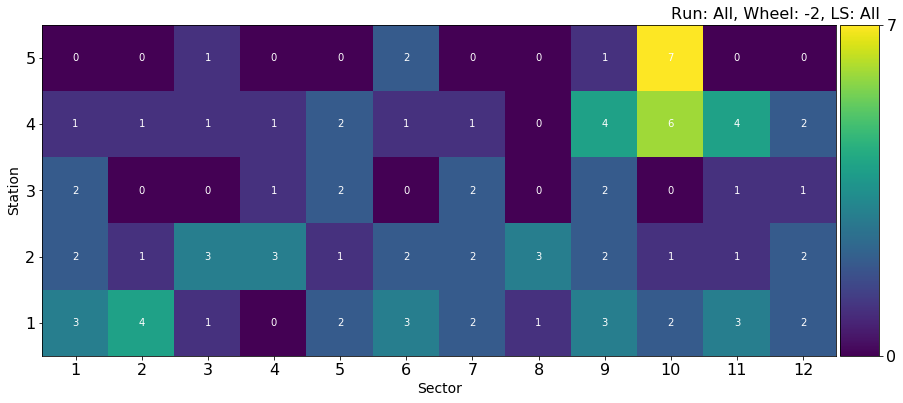

[[0 0 0 0 0 0 0 0 0 2 0 2]
 [0 1 0 1 1 1 0 2 3 5 2 1]
 [1 2 0 0 1 0 0 2 2 1 2 3]
 [0 2 0 0 0 0 0 0 2 0 0 1]
 [2 1 3 4 2 1 3 3 1 1 1 1]]
63


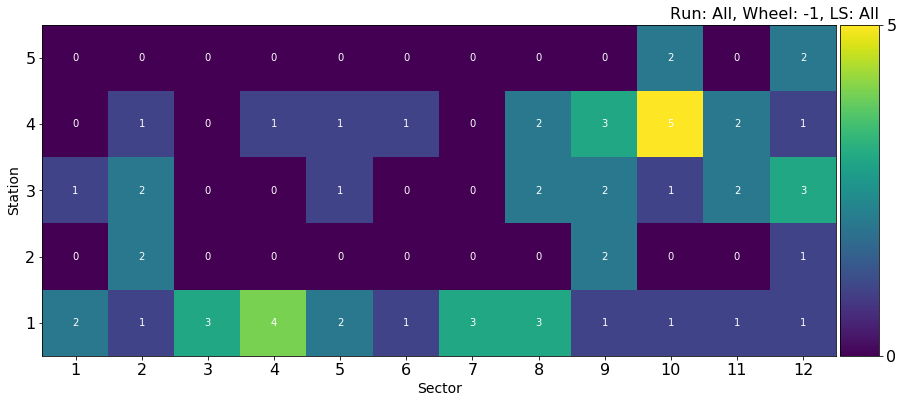

[[0 0 0 4 0 0 0 0 0 6 0 6]
 [2 0 0 0 0 1 2 2 3 3 7 1]
 [1 1 0 2 0 0 0 1 2 0 2 1]
 [1 2 0 1 0 0 0 0 1 1 0 1]
 [1 1 2 5 1 2 2 1 1 4 2 3]]
79


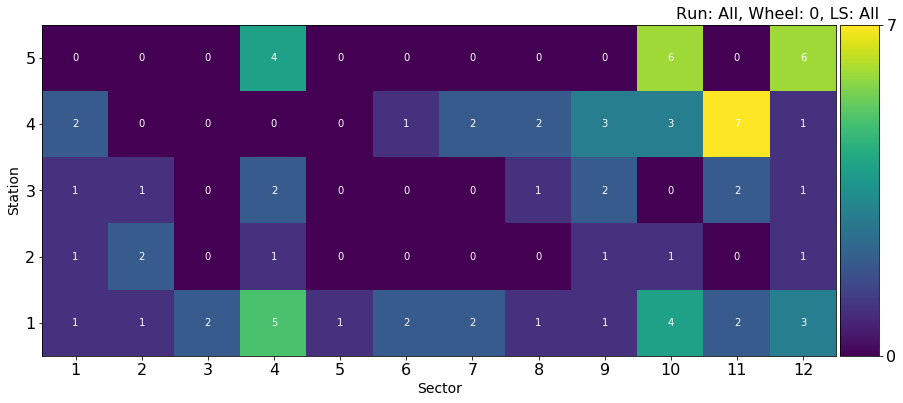

[[0 0 0 1 0 0 0 2 0 3 0 0]
 [0 1 1 1 0 1 1 1 2 0 3 3]
 [1 2 0 0 3 1 0 2 1 2 3 0]
 [1 0 0 0 1 0 1 0 2 1 0 1]
 [3 2 3 1 3 5 0 1 2 0 0 2]]
64


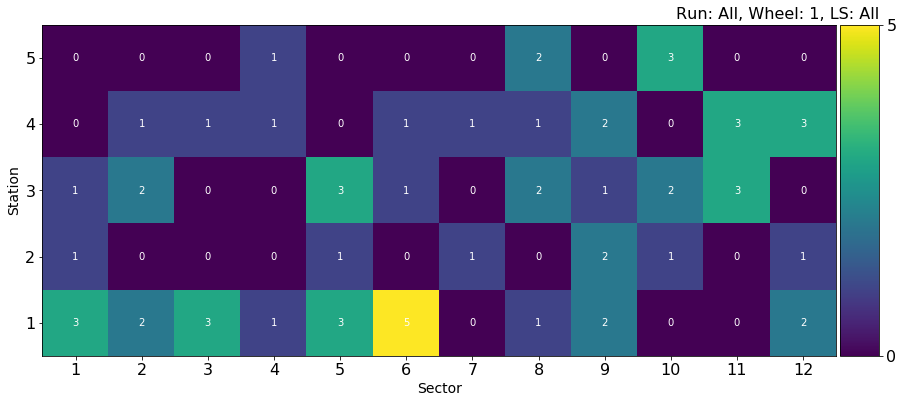

[[3 0 0 0 0 0 0 1 0 6 0 5]
 [3 1 0 0 0 0 2 0 3 4 2 2]
 [0 1 0 0 3 0 0 1 1 1 1 1]
 [2 1 4 2 2 1 2 3 3 1 4 3]
 [2 1 1 3 3 4 1 2 5 2 2 1]]
96


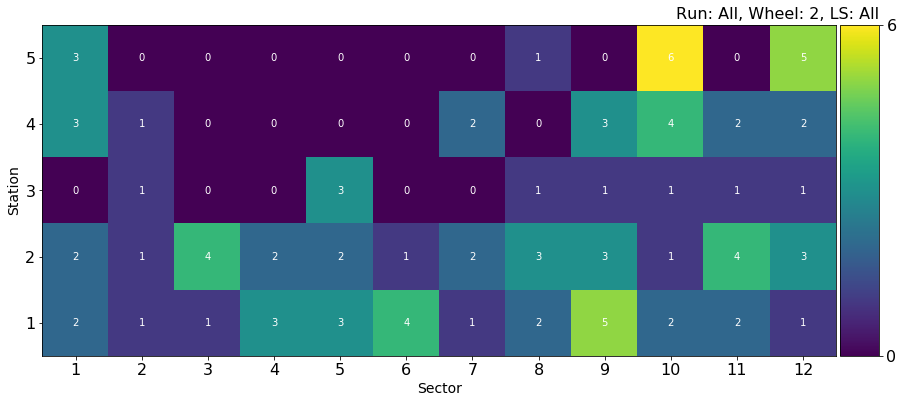

In [815]:
def plot_scatter(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print mat
    print mat.sum()

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

th = 0.035
dis_nn = "cae_score"
rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th)
plot_scatter(layers_test[rule], 306125, -3, 210, 230)

plot_scatter(layers_test[rule], -1, -2, -1, -1)
plot_scatter(layers_test[rule], -1, -1, -1, -1)
plot_scatter(layers_test[rule], -1, 0, -1, -1)
plot_scatter(layers_test[rule], -1, +1, -1, -1)
plot_scatter(layers_test[rule], -1, +2, -1, -1)

Where are the FPs located in time?

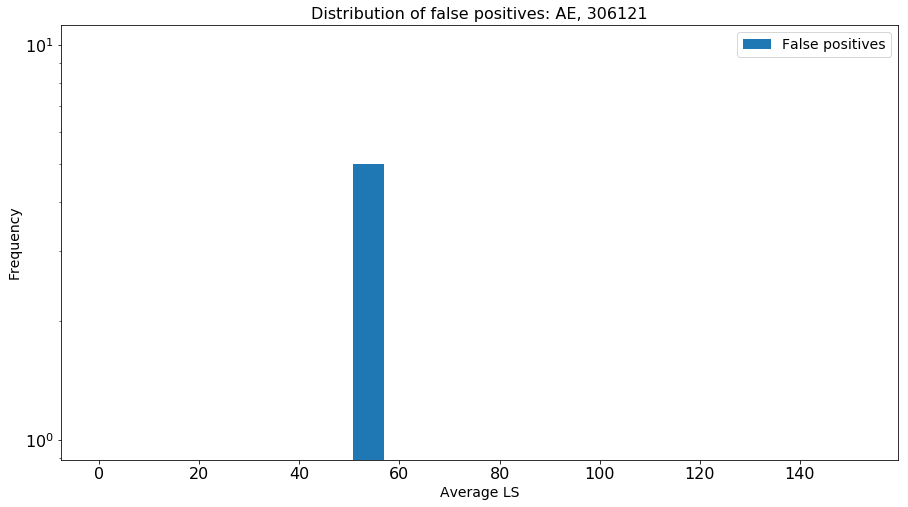

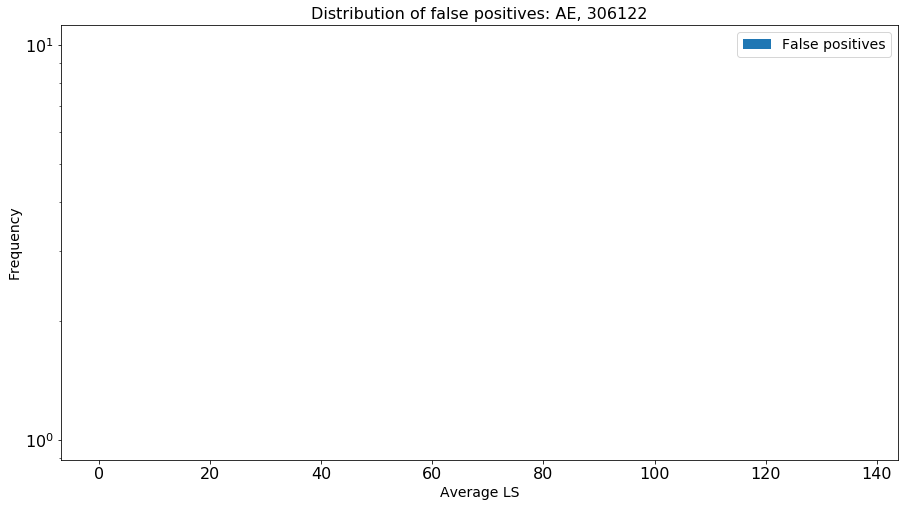

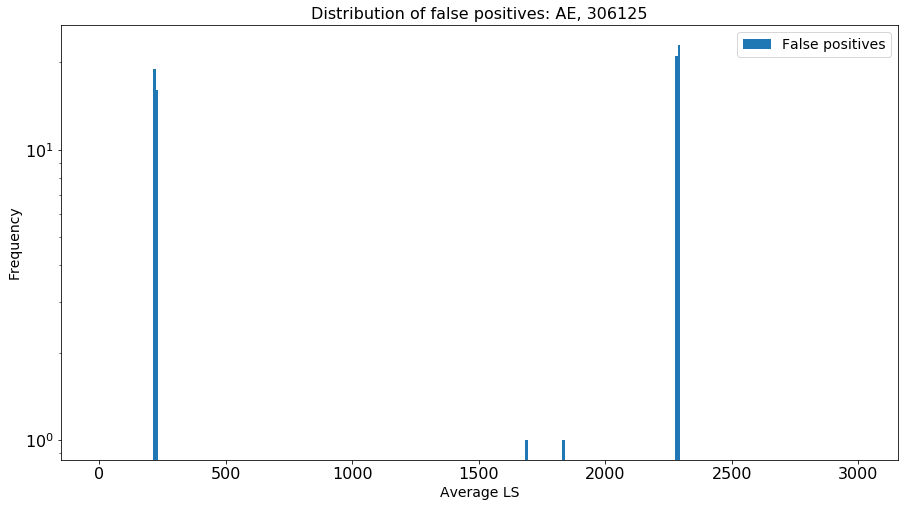

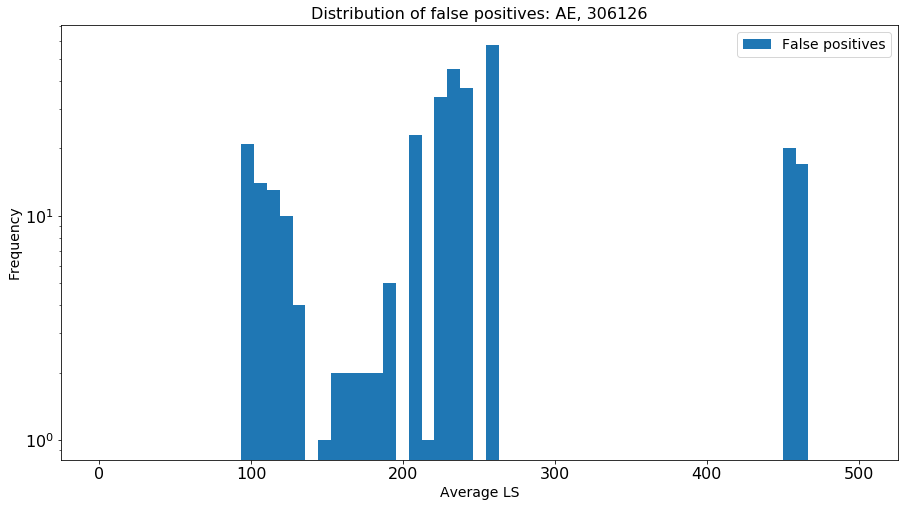

In [816]:
def plotFpVsLs(run, wheel, sector, station, title, df, algo, threshold, log, bound):
    fig, ax = plt.subplots()
    if log:
        ax.set_yscale('log')
    bins = np.linspace(0, bound, int(bound/10)+10)
    plt.hist(df[(df["score"] == -1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, label="False positives")
    plt.title(title+str(run))
    plt.legend(loc='best')
    plt.ylabel('Frequency')
    plt.xlabel('Average LS')
    #plt.plot([bound, bound], [0, 100], color='r', linestyle='--', linewidth=2)
    plt.show()
    
threshold = 0.035
plotFpVsLs(306121, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 306121]["ls_end"])
plotFpVsLs(306122, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 306122]["ls_end"])
plotFpVsLs(306125, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 306125]["ls_end"])
plotFpVsLs(306126, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 306126]["ls_end"])

Trying some benchmark algorithms (for outlier detection). Isolation forest:

In [400]:
def variance(content):
    return np.var(content)
layers_test["variance_score"] = layers_test["content"].apply(variance)

In [95]:
#print layers_test["variance_score"]

In [170]:
def cross_validation_split(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [97]:
param_grid = [{"max_samples": [100, 1000],
               "n_estimators": [10, 100],
               "contamination": np.array(range(4, 13, 1))/100.0}]

ifparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
                                 -layers_train["score"].astype(int),
                                 IsolationForest(random_state=rng, 
                                                 #verbose=1
                                                ),
                                 param_grid)

In [98]:
# Retrain IF using all unlabelled samples

ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)

ifclf.fit(np.vstack(normalies_train["content_scaled"].values))

IsolationForest(bootstrap=False, contamination=0.040000000000000001,
        max_features=1.0, max_samples=100, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x116674b40>, verbose=0)

Then use SVM for outlier detection:

In [ ]:
# This may take some time... to be run on a remote machine possibly on GPU

#param_grid = [{"nu": np.array(range(1, 10, 1))/10.0,
#               "gamma": ["auto", 0.1, 0.01, 0.001, 0.0001],
#               "kernel": ["linear", "rbf"]}]

#svmparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
#                                  -layers_train["score"].astype(int),
#                                  svm.OneClassSVM(random_state=rng, 
#                                                  verbose=1
#                                                 ),
#                                  param_grid)

In [172]:
# Retrain SVM using only good samples. For the moment using some temporary values.
svmclf = svm.OneClassSVM(
                         #nu=svmparams.nu,
                         nu=0.2,
                         #gamma=svmparams.gamma,
                         gamma=0.1,
                         kernel='linear',
                         random_state=rng
                        )
svmclf.fit(np.vstack(normalies_train["content_scaled"].values))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='linear',
      max_iter=-1, nu=0.2,
      random_state=<mtrand.RandomState object at 0x1433f1f00>,
      shrinking=True, tol=0.001, verbose=False)

In [173]:
layers_test["svm_score"] = -svmclf.decision_function(np.vstack(layers_test["content_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(np.vstack(layers_test["content_scaled"].values))

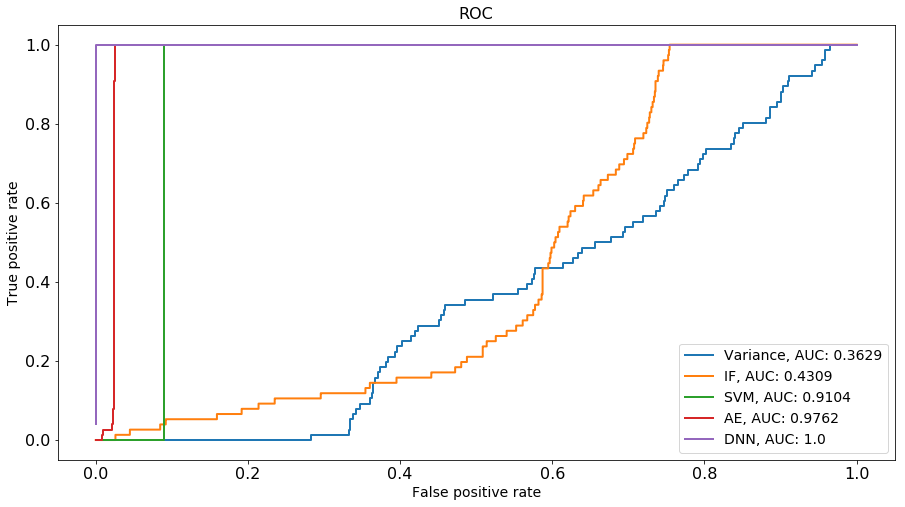

In [174]:
get_roc_curve(layers_test,[("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("DNN", "ann_score_4"),
                          ]
             )

Trying KNeighborsClassifier classifier:

In [175]:
from sklearn import neighbors
knclf = neighbors.KNeighborsClassifier(5, weights='distance')
knclf.fit(np.vstack(layers_train["content_scaled"].values),\
          -layers_train["score"].astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [176]:
layers_test["knn_score"] = -knclf.predict(np.vstack(layers_test["content_scaled"].values))

Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


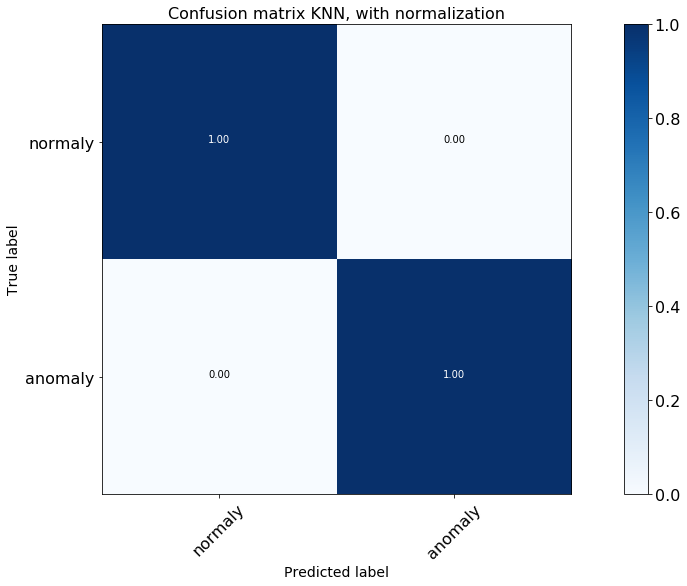

In [177]:
threshold = 0.0
y_pred = 2*(layers_test["knn_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix KNN, with normalization')

Trying unsupervised algorithms:

In [178]:
def removeItem(data):
    index = [4, 5, 6, 7]
    temp = data.copy()
    temp = np.delete(temp, index)
    return temp

layers_train["content_scaled_2"] = layers_train["content_scaled"].apply(removeItem)

In [207]:
# fit the model
from sklearn.neighbors import LocalOutlierFactor
lofclf = LocalOutlierFactor(n_neighbors=5555)
layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))

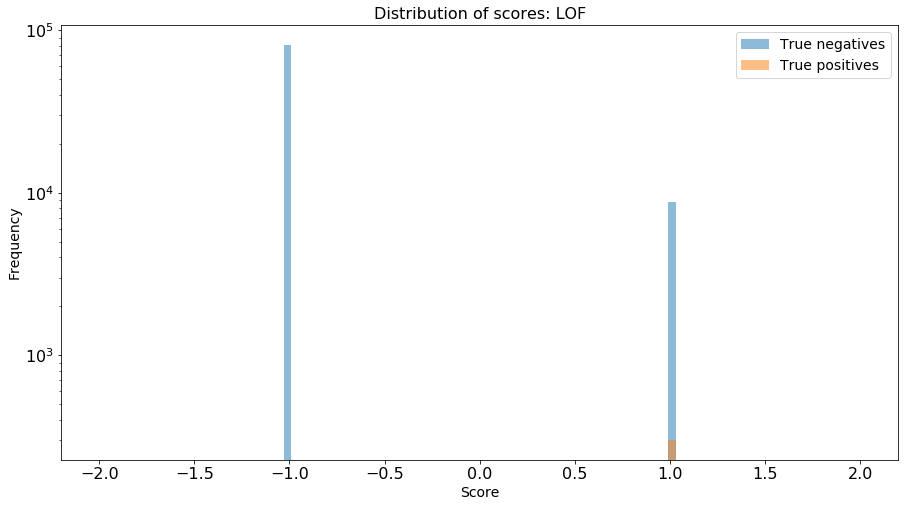

In [208]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(-2, +2, 100)
plt.hist(layers_train[layers_train["score"] < 0]["lof_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_train[layers_train["score"] > 0]["lof_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

Normalized confusion matrix
[[ 0.90299202  0.09700798]
 [ 0.          1.        ]]


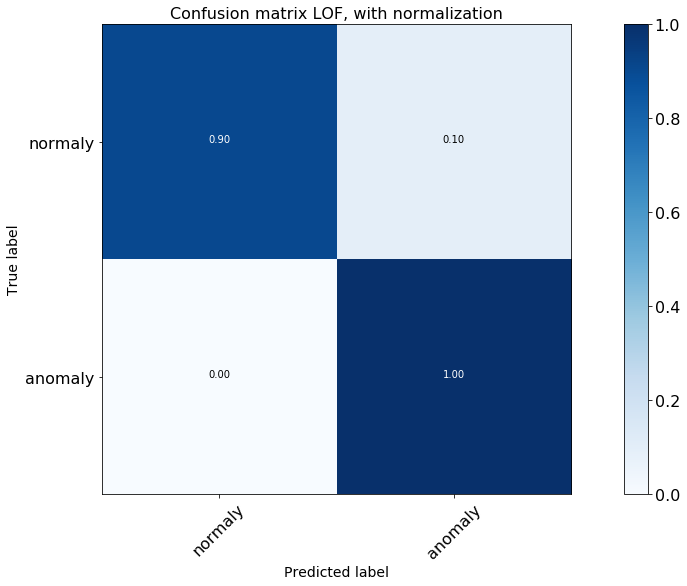

In [209]:
threshold = 0.0
y_pred = 2*(layers_train["lof_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_train["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix LOF, with normalization')

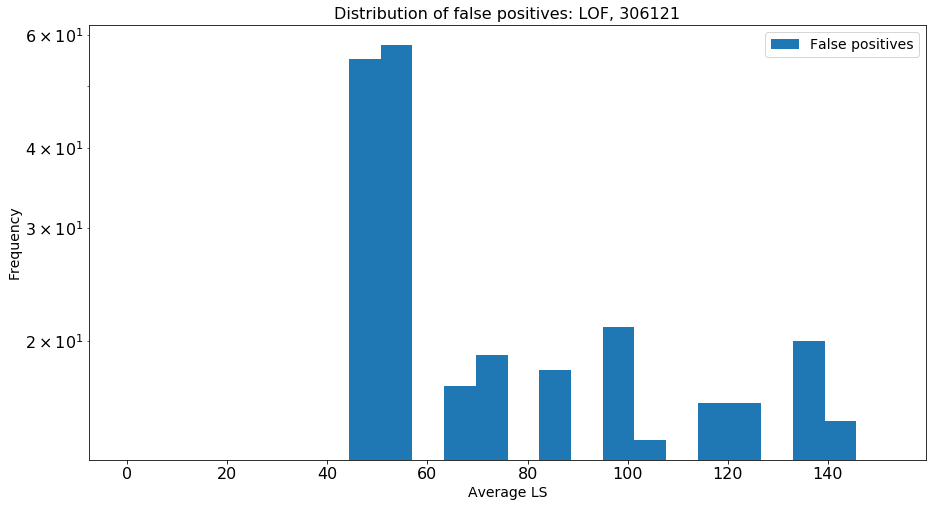

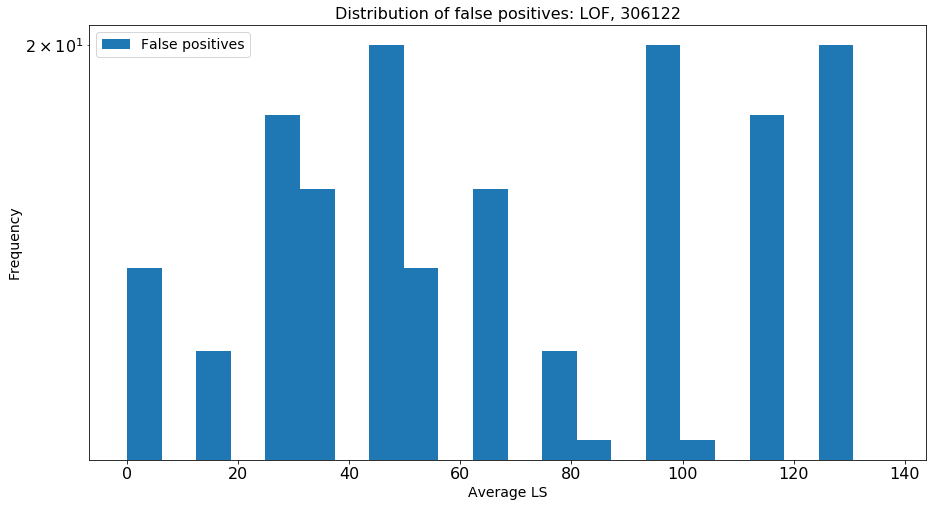

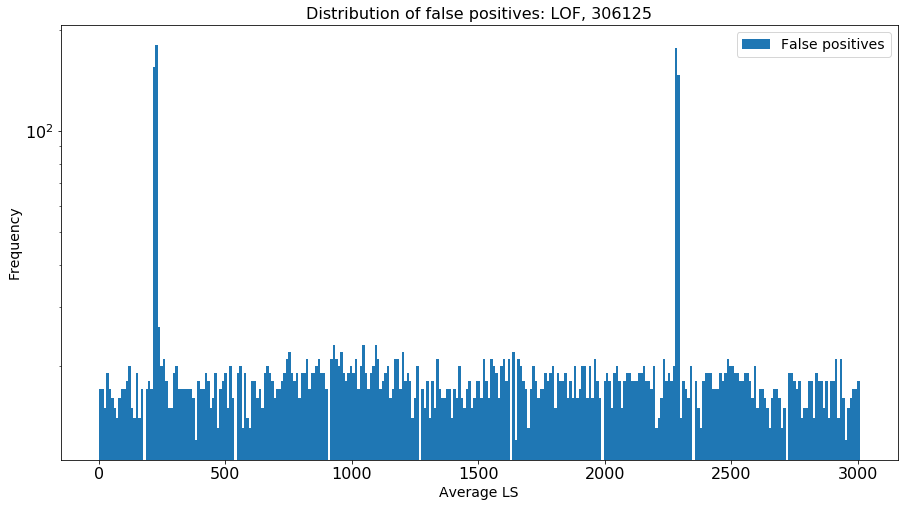

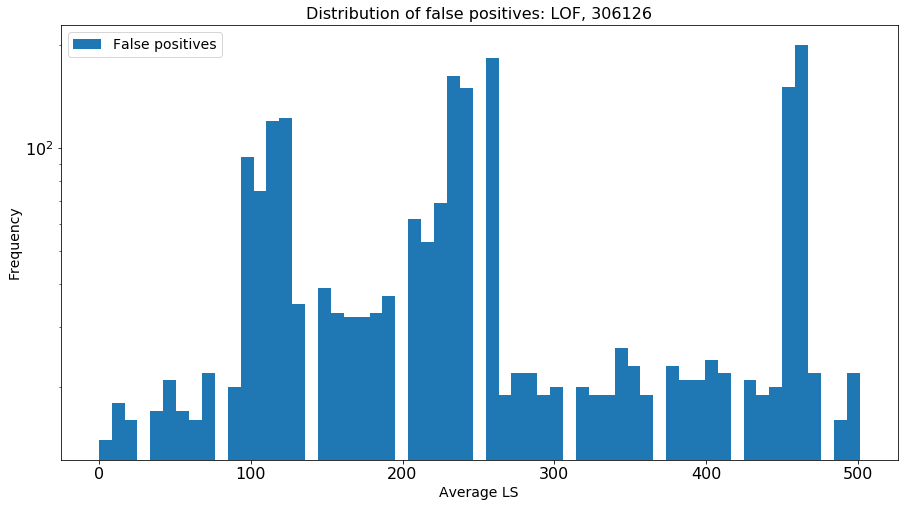

In [210]:
layers_train["averageLS"] = layers_train["group"].apply(deduceLS)
threshold = 0.0
plotFsVsLs(306121, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306121]["ls_end"])
plotFsVsLs(306122, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306122]["ls_end"])
plotFsVsLs(306125, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306125]["ls_end"])
plotFsVsLs(306126, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306126]["ls_end"])

In [196]:
from sklearn import cluster, datasets
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(np.vstack(layers_train["content_scaled_2"].values)) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [197]:
def convert_score(data):
    score = 2*(data == 0)-1
    return score

layers_train["kmeans_score"] = k_means.labels_
layers_train["kmeans_score"] = layers_train["kmeans_score"].apply(convert_score)

Normalized confusion matrix
[[ 0.00237145  0.99762855]
 [ 0.          1.        ]]


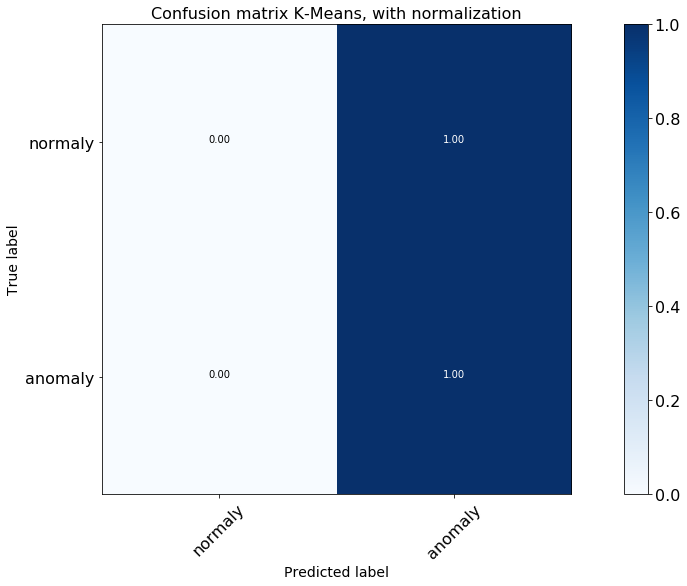

In [198]:
threshold = 0.0
y_pred = layers_train["kmeans_score"]
cnf_matrix = confusion_matrix(layers_train["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix K-Means, with normalization')